# Load Libraries

In [37]:
import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *

from scipy.stats import norm
from scipy import stats

# Generate synthetic data

In [39]:
# Load the country dataset
country_df = pd.read_csv('data/country.csv')

# Load the business dataset
business_df = pd.read_csv('data/business.csv')

# Load the job dataset
job_df = pd.read_csv('data/jobs.csv')

# load the level dataset
level_df = pd.read_csv('data/levels.csv')

# load the level dataset
rating_df = pd.read_csv('data/ratings.csv')


In [40]:
# Set the seed
seed_value = 888
random.seed(seed_value)
np.random.seed(seed_value)


In [41]:
# Initialize an empty list to store the generated employee data
employees = []

# Define the probabilities
probrace = [0.1, 0.9]  # Black, White
labelsrace = ['Black', 'White']

probsex = [0.4, 0.6]  # Female, Male
labelsex = ['Female', 'Male']

prob_male = [0.80, 0.10, 0.05, 0.025, 0.025]
awards_male = [0, 1, 2, 3, 4]

prob_female = [0.9, 0.05, 0.025, 0.0125, 0.0125]
awards_female = [0, 1, 2, 3, 4]


biasFemale = 0.98 #Female get paid this vs Men
biasBlack = 0.98 #Blacks get paid this vs Female

# Define the probabilities for award based on sex
#male_prob = [0.07, 0.93]  # 5% chance of 'Yes', 95% chance of 'No'
#female_prob = [0.05, 0.95]  # 2% chance of 'Yes', 98% chance of 'No'


# Generate employee data based on country, business, and job datasets
for _, country_row in country_df.iterrows():
    country = country_row['country']
    headcount = country_row['headcount']
    avg_salary = country_row['avg_salary']
    
    for _,business_row in business_df.iterrows():
        business = business_row['business']
        business_pct = business_row['pct_pop']
        business_salary = business_row['salary_index']
        business_std = business_row['std_dev']

        for _,job_row in job_df.iterrows():
            job_code = job_row['job_code']
            job_pct = job_row['pct_pop']
            job_salary = job_row['salary_index']
            job_std = job_row['std_dev']

            
            for _,level_row in level_df.iterrows():
                level_code = str(level_row['job_level'])
                level_pct = level_row['pct_pop']
                level_salary = level_row['salary_index']
                level_std = level_row['std_dev']

                for _,rating_row in rating_df.iterrows():
                    rating_code = str(rating_row['rating'])
                    rating_pct = rating_row['pct_pop']
                    rating_salary = rating_row['salary_index']
                    rating_std = rating_row['std_dev']
                    
                    num_people = int(headcount*business_pct*job_pct*level_pct*rating_pct)
                    
                    for person in range(num_people):
                        race_emp = np.random.choice(labelsrace, p=probrace)
                        sex_emp = np.random.choice(labelsex, p=probsex)
                        
                        if race_emp == 'Black':
                            biasRace = biasBlack
                        else:
                            biasRace = 1
                        
                        if sex_emp == 'Female':
                            biasSex = biasFemale
                            award = random.choices(awards_female, prob_female)[0]
                        else:
                            biasSex = 1
                            award = random.choices(awards_male, prob_male)[0]


                            
                        employee_id = "EMP-"+country[-2:]+business[-2:]+job_code[-2:]+level_code[-2:]+rating_code+str(person)
                        
                        b_index = np.random.normal(business_salary, business_std)
                        j_index = np.random.normal(job_salary, job_std)
                        l_index = np.random.normal(level_salary, level_std)
                        r_index = np.random.normal(rating_salary, rating_std)
                        employee_salary = avg_salary * b_index * j_index * l_index * r_index * biasRace * biasSex
                        
                        employee_data = {'Employee_id': employee_id,
                                         'Country': country,
                                         'Business': business,
                                         'Job': job_code,
                                         'Level': level_code,
                                         'Rating' : rating_code,
                                         'Salary': employee_salary,
                                         'Race' : race_emp,
                                         'Sex' : sex_emp,
                                         'Awards' : award}
                        
                        employees.append(employee_data)

# Create the final DataFrame
employee_df = pd.DataFrame(employees)

## Review data generated

In [42]:
# Print the first few rows of the synthetic employee dataset
employee_df.head()
 

,Employee_id,Country,Business,Job,Level,Rating,Salary,Race,Sex,Awards
0,EMP-_1RP01L11.00,Country_1,CORP,Job_Code_001,L1,1.0,110153.498927,White,Female,0
1,EMP-_1RP01L11.01,Country_1,CORP,Job_Code_001,L1,1.0,107581.578469,White,Male,0
2,EMP-_1RP01L11.02,Country_1,CORP,Job_Code_001,L1,1.0,120892.348763,Black,Female,1
3,EMP-_1RP01L11.03,Country_1,CORP,Job_Code_001,L1,1.0,110724.744901,White,Female,0
4,EMP-_1RP01L11.04,Country_1,CORP,Job_Code_001,L1,1.0,104284.628410,White,Female,0


In [43]:
employee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199984 entries, 0 to 199983
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Employee_id  199984 non-null  object 
 1   Country      199984 non-null  object 
 2   Business     199984 non-null  object 
 3   Job          199984 non-null  object 
 4   Level        199984 non-null  object 
 5   Rating       199984 non-null  object 
 6   Salary       199984 non-null  float64
 7   Race         199984 non-null  object 
 8   Sex          199984 non-null  object 
 9   Awards       199984 non-null  int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 15.3+ MB


In [44]:
#employee_df.groupby('Country').count()['Employee_id']

In [45]:
def to_k_format(x, pos):
    """Format the tick values to 'K' format."""
    return '{:.0f}K'.format(x * 1e-3)


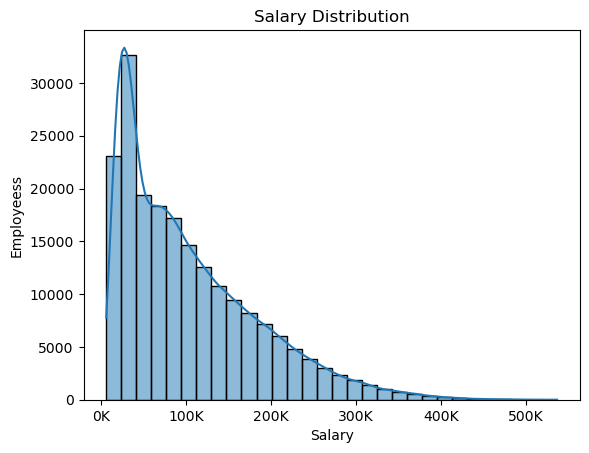

In [46]:
from matplotlib.ticker import FuncFormatter

sns.histplot(employee_df['Salary'], kde=True, bins=30)
# Set the x-axis formatter
formatter = FuncFormatter(to_k_format)
plt.gca().xaxis.set_major_formatter(formatter)

plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Employeess')
plt.show()


In [47]:
pd.DataFrame(employee_df.groupby('Country')['Employee_id'].count())

,Employee_id
Country,
Country_1,49996
Country_2,49996
Country_3,49996
Country_4,49996


In [48]:
pd.DataFrame(employee_df.groupby('Business')['Employee_id'].count())

,Employee_id
Business,
CORP,80000
SALES,119984


In [49]:
pd.DataFrame(employee_df.groupby('Job')['Employee_id'].count())

,Employee_id
Job,
Job_Code_001,60000
Job_Code_002,49992
Job_Code_003,40000
Job_Code_004,49992


In [50]:
pd.DataFrame(employee_df.groupby('Level')['Employee_id'].count())

,Employee_id
Level,
L1,40000
L2,40000
L3,49992
L4,40000
L5,29992


In [51]:
pd.DataFrame(employee_df.groupby('Rating')['Employee_id'].count())

,Employee_id
Rating,
1.0,40000
2.0,59992
3.0,59992
4.0,40000


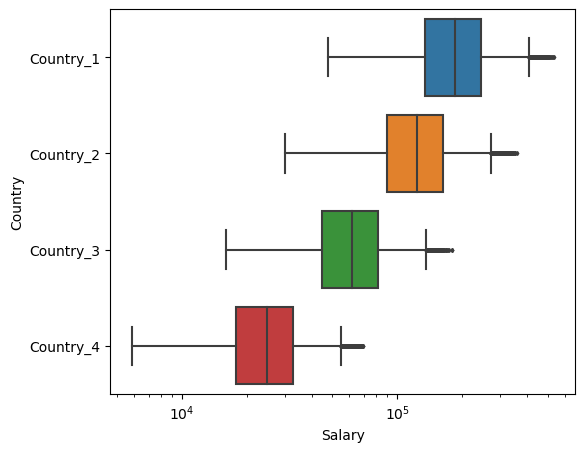

In [60]:
plt.figure(figsize=(6, 5))

average_salary = employee_df.groupby('Country')['Salary'].mean().sort_values(ascending=False)
employee_df_sorted = employee_df.loc[employee_df['Country'].isin(average_salary.index)]

sns.boxplot(data=employee_df_sorted, y='Country', x='Salary', orient='h', order=average_salary.index, fliersize=2)
plt.xscale('log')
plt.show()

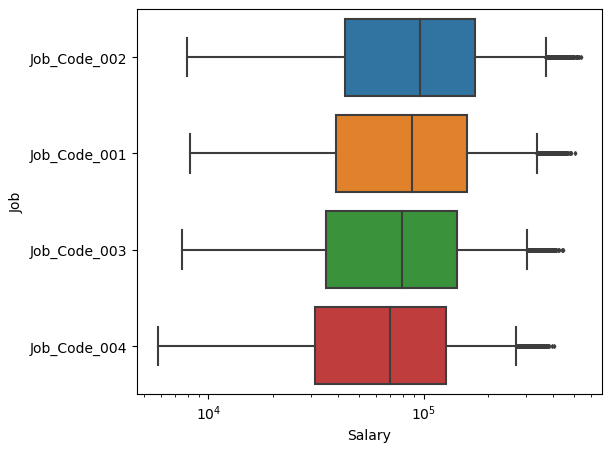

In [61]:
plt.figure(figsize=(6, 5))

average_salary = employee_df.groupby('Job')['Salary'].mean().sort_values(ascending=False)
employee_df_sorted = employee_df.loc[employee_df['Job'].isin(average_salary.index)]

sns.boxplot(data=employee_df_sorted, y='Job', x='Salary', orient='h', order=average_salary.index, fliersize=2)
plt.xscale('log')
plt.show()

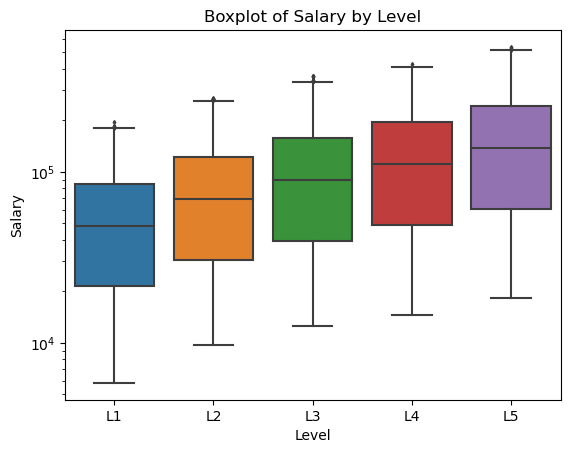

In [62]:
sns.boxplot(x='Level', y='Salary', data=employee_df, fliersize=2)
plt.yscale('log')
plt.title('Boxplot of Salary by Level')
plt.xlabel('Level')
plt.ylabel('Salary')
plt.show()

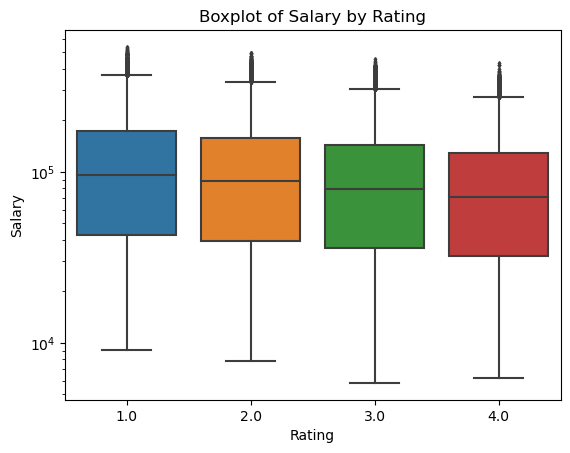

In [63]:
sns.boxplot(x='Rating', y='Salary', data=employee_df, fliersize=2)
plt.yscale('log')
plt.title('Boxplot of Salary by Rating')
plt.xlabel('Rating')
plt.ylabel('Salary')
plt.show()

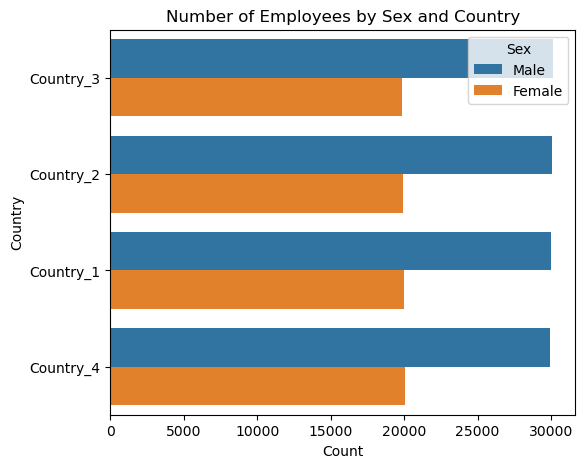

In [64]:
# Calculate the count of employees by country and sex
count_data = employee_df.groupby(['Country', 'Sex']).size().reset_index(name='count')

# Sort the count_data DataFrame by the count column in descending order
count_data = count_data.sort_values(by='count', ascending=False)

# Plot the stacked bar plot with larger figure size
plt.figure(figsize=(6, 5))
sns.barplot(x='count', y='Country', hue='Sex', data=count_data, orient='h')

# Set plot title and axis labels
plt.title('Number of Employees by Sex and Country')
plt.xlabel('Count')
plt.ylabel('Country')

plt.show()

## Save generated data to .CSV

In [65]:
employee_df.to_csv("data/employees7.csv",index=False)

# Read data from .CSV

In [58]:
employee_df = pd.read_csv("employees7.csv")
employee_df.head(10)

,Employee_id,Country,Business,Job,Level,Rating,Salary,Race,Sex,Awards
0,EMP-_1RP01L11.00,Country_1,CORP,Job_Code_001,L1,1.0,110153.498927,White,Female,0
1,EMP-_1RP01L11.01,Country_1,CORP,Job_Code_001,L1,1.0,107581.578469,White,Male,0
2,EMP-_1RP01L11.02,Country_1,CORP,Job_Code_001,L1,1.0,120892.348763,Black,Female,1
3,EMP-_1RP01L11.03,Country_1,CORP,Job_Code_001,L1,1.0,110724.744901,White,Female,0
4,EMP-_1RP01L11.04,Country_1,CORP,Job_Code_001,L1,1.0,104284.628410,White,Female,0
5,EMP-_1RP01L11.05,Country_1,CORP,Job_Code_001,L1,1.0,82494.514025,White,Male,0
6,EMP-_1RP01L11.06,Country_1,CORP,Job_Code_001,L1,1.0,99889.981934,White,Female,0
7,EMP-_1RP01L11.07,Country_1,CORP,Job_Code_001,L1,1.0,127163.367185,Black,Male,1
8,EMP-_1RP01L11.08,Country_1,CORP,Job_Code_001,L1,1.0,125236.459252,White,Male,0
9,EMP-_1RP01L11.09,Country_1,CORP,Job_Code_001,L1,1.0,131425.461246,White,Male,0


# Start Machine Learning

In [23]:
X = employee_df.drop(["Salary"], axis=1)
y = employee_df["Salary"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=69)

In [26]:
# Initialze the estimators
reg1 = XGBRegressor(random_state=69)
reg2 = LinearRegression()


In [27]:
#Initiaze the hyperparameters for each dictionary
# This one below took 4 hour but it was BEST!
param1 = {}
param1['regression__n_estimators'] = [1000]
param1['regression__max_depth'] = [20]
param1['regression__min_child_weight'] = [10]
param1['regression__learning_rate'] = [0.05]
param1['regression'] = [reg1]

param2 = {}
param2['regression'] = [reg2]

params = [param1, param2]
#params = [param2]

In [28]:
# Define the column names for hot encoding
hot_encode_columns = ["Country","Business","Job","Level", "Rating"]

# Create the transformers for your pipeline
column_transformer = ColumnTransformer(
    transformers=[
        ('hot_encode', OneHotEncoder(), hot_encode_columns),
        ('ignore', 'drop', ['Employee_id','Race','Sex']),  
        # ('keep', 'passthrough', ['Rating'])  
    ],
    remainder='drop'  # Drop any remaining columns
)

# Define the regression model
#regressor = LinearRegression()

# Create the pipeline
pipeline = Pipeline([
    ('preprocessing', column_transformer),
    ('regression', reg1)], verbose=True)


# Train Model !

In [29]:
start_time = time.time()

#### Gridsearch CV
gs = GridSearchCV(pipeline, params, cv=5, n_jobs= -1, scoring='neg_mean_absolute_percentage_error', 
                  verbose = 4, return_train_score=True).fit(X_train, y_train)

(time.time() - start_time) /60

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.2s
[Pipeline] ........ (step 2 of 2) Processing regression, total=  36.6s


4.44081050157547

# Review Results of Machine Learning

In [30]:
# Best performing model and its corresponding hyperparameters
gs.best_params_


{'regression': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...),
 'regression__learning_rate': 0.05,
 'regression__max_depth': 20,
 'regression__min_child_weight': 10,
 'regression__n_estimators': 1000}

In [31]:
gs.best_score_

-0.08040193215129043

In [32]:
print("Test R2 Score:",r2_score(gs.predict(X_test), y_test))
print("Test neg. RMSE Score:",mean_squared_error(gs.predict(X_test), y_test))
print("Test neg. MAPE Score:",mean_absolute_percentage_error(gs.predict(X_test), y_test))


Test R2 Score: 0.9764985119395202
Test neg. RMSE Score: 150746764.9136264
Test neg. MAPE Score: 0.07910896078834297


In [33]:
# Get the best model from GridSearchCV
best_model = gs.best_estimator_

# Retrieve the underlying XGBoost model from the Pipeline
xgb_model = best_model.named_steps['regression']  # Replace 'xgb' with the appropriate name of your XGBoost step in the Pipeline


In [12]:
#!pip install graphviz

     ---------------------------------------- 47.0/47.0 kB 2.5 MB/s eta 0:00:00


In [15]:
import xgboost as xgb
import graphviz

# Assuming you have already trained an XGBoost model and stored it in `xgb_model`

# Select the index of the tree you want to visualize
tree_index = 0

# Set the maximum depth to 2
max_depth = 2

# Export the selected tree as a Graphviz DOT file
dot_data = xgb.to_graphviz(xgb_model, num_trees=tree_index, yes_color='#0000FF', no_color='#FF0000', max_depth=max_depth)

# Render the graph as PDF
dot_data.format = 'pdf'
#dot_data.render('tree_plot')

# Alternatively, render the graph as PNG
dot_data.format = 'png'
#dot_data.render('tree_plot')

# Display the graph in Jupyter Notebook or IPython THE WHOLE TREE !!!

#dot_data


In [14]:
# SAVE MODEL
import pickle

with open('model_python_salary_outlier5.pkl','wb') as f:
    pickle.dump(gs,f)


# Load Trained Model

In [15]:
import pickle
# load
with open('model_python_salary_outlier5.pkl', 'rb') as f:
    gs = pickle.load(f)

#gs.predict(X)

# Evaluate Trained Model

In [34]:
my_predictions = pd.DataFrame(gs.predict(X_test))

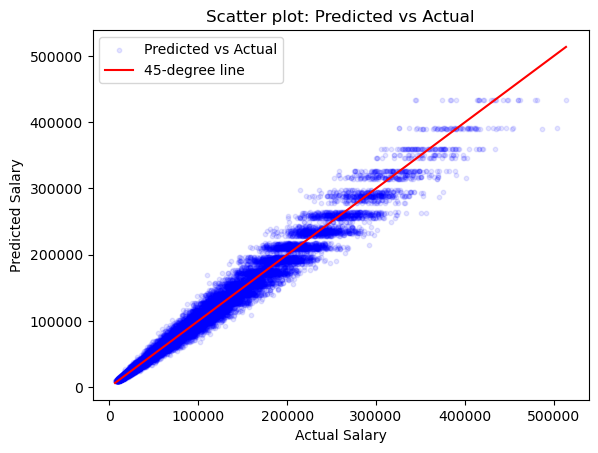

In [35]:
# Create a scatter plot
plt.scatter(y_test, my_predictions, color='b', label='Predicted vs Actual', s=10,alpha=0.1)

# Plot the 45-degree line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],color='r', label='45-degree line')


# Set labels and title
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Scatter plot: Predicted vs Actual')

# Add legend
plt.legend()

# Show the plot
plt.show()

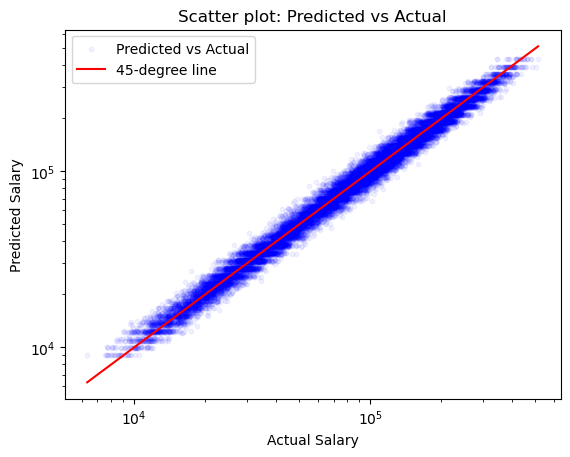

In [36]:
# Create a scatter plot, with LOG Scales
plt.scatter(y_test, my_predictions, color='b', label='Predicted vs Actual', s=10,alpha=0.05)

# Plot the 45-degree line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],color='r', label='45-degree line')

#
plt.xscale('log')
plt.yscale('log')


# Set labels and title
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Scatter plot: Predicted vs Actual')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [74]:
#############################################################################################################

In [65]:
#############################################################################################################